# Looking for signals of attention (and other mental states) in macaque V2

In [5]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import torch
import pickle
import os.path
import numpy as np
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from copy import deepcopy

# NDNT network libs
import NDNT.utils as utils
import NDNT.NDNT as NDN
from NDNT.modules.layers import ChannelLayer, NDNLayer
from NDNT.networks import FFnetwork

import utils as ut
import lvutils as lv
import mattplotlib as m
import modellib as ml

def redo():
    reload(ut)
    reload(lv)
    reload(m)
    reload(ml)

In [6]:
# load the data
data = ut.load_data('ki_0503_V2b_py.mat')

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


# Build and Train the Models Independently

## Define the LBFGS params

In [23]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=2000,
    history_size=100,
    max_epochs=3,
    max_iter=2000)

## Train NULL (DRIFT) Model

Mean LL-Drift: 2.50825


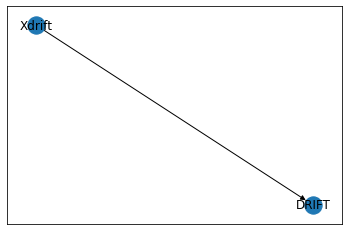

In [152]:
# define the DRIFT, train it before adding it to the network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='softplus')
drift_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}

drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])

# Stand-alone drift model
drift_mod = NDN.NDN(ffnet_list=[drift_net], loss_type='poisson')


# Train the DRIFT Model
drift_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
# evaluate model using null-adjusted log-likelihood
LLsDrift = drift_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Drift:", np.mean(LLsDrift))

ml.draw_network(drift_mod, names=['DRIFT'])

<Figure size 432x288 with 0 Axes>

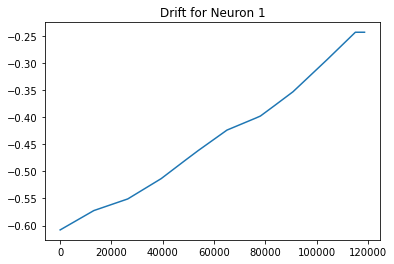

In [153]:
# Check that DRIFT model weights (e.g. predictions), try to make them smoother

# get the weights for the DRIFT network
driftw = drift_mod.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape
# predict the firing rates from the DRIFT
predRs = data.Xdrift @ driftw

m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

## Create Xadapt features

<Figure size 432x288 with 0 Axes>

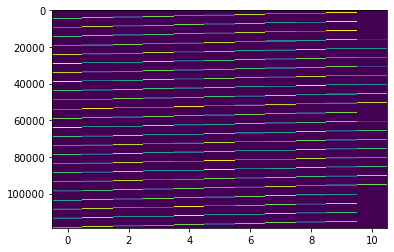

In [131]:
Xadapt = np.zeros((data.NT, 11))
for trial in data.block_inds:
    tents = data.design_matrix_drift(120, [i for i in range(10, 120, 10)])
    # copy this for each trial into the long list of tents
    Xadapt[trial[0]:trial[-1]] = tents[0:trial[-1]-trial[0]]

# this one only populates the first trial with tents,
# we need to populate the rest of the trials with tents
m.fig()
plt.imshow(Xadapt, aspect='auto', interpolation='none')
plt.show()

## Train ADAPT Model

Mean LL-Adapt: -0.23819046


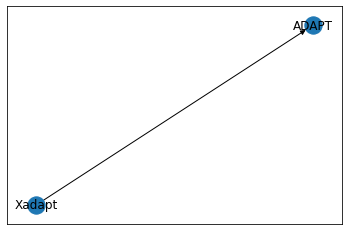

In [148]:
data.add_covariate('Xadapt', Xadapt)

# define the ADAPT, train it before adding it to the network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, Xadapt.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='softplus')
adapt_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}

adapt_net = FFnetwork.ffnet_dict(xstim_n='Xadapt', layer_list=[adapt_pars])

# Stand-alone drift model
adapt_mod = NDN.NDN(ffnet_list=[adapt_net], loss_type='poisson')

# Train the ADAPT model
adapt_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
# evaluate model using null-adjusted log-likelihood
LLsAdapt = adapt_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsAdapt))

ml.draw_network(adapt_mod, names=['ADAPT'])


<Figure size 432x288 with 0 Axes>

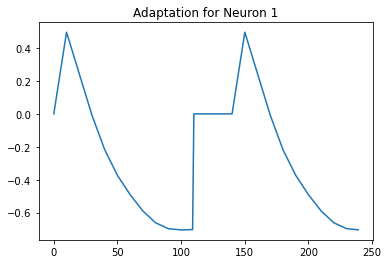

In [149]:
# Check that ADAPT model weights (e.g. predictions), try to make them smoother

# get the weights for the ADAPT network
adaptw = adapt_mod.networks[0].layers[0].weight.data
data.Xdrift.shape, adaptw.shape
# predict the firing rates from the DRIFT
predRs = torch.tensor(Xadapt, dtype=torch.float) @ adaptw

m.fig()
plt.plot(predRs[:,0][:240])
plt.title("Adaptation for Neuron 1")
plt.show()

## Train STIM Model

Mean LLsGLM: 0.047792505


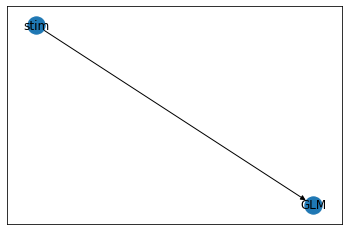

In [157]:
# define the GLM, train it before adding it to the network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=True,
    initialize_center=True,
    NLtype='softplus') # use linear output since it is a layer of the larger model

# regularization method (use d2xt with lambda weight 0.02)
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}

# only return the FFnetwork wrapped NDNLayer when combining this with other layers
stim_network = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])

stim_mod = NDN.NDN(ffnet_list=[stim_network], loss_type='poisson')

# Train the STIM model
stim_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
LLsGLM = stim_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LLsGLM:", np.mean(LLsDrift - LLsGLM))


ml.draw_network(stim_mod, names=['GLM'])

# Combine the networks and train all together

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.6594345569610596 sec elapsed
Mean LL-Adapt: 0.07795681


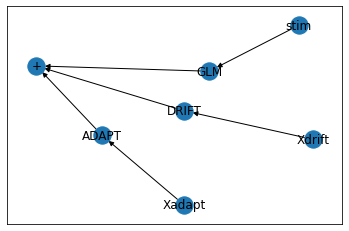

In [159]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, Xadapt.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='Xadapt', layer_list=[adapt_pars])


# define the GLM network
glm_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
glm_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
glm_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[glm_layer])

# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC, 
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMBINED model
model = NDN.NDN(ffnet_list=[drift_net, adapt_net, glm_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)

# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Q: are the val_inds setup correctly for validation?
#    yes, the Dataset does this automatically
# Q: are there left out test values to compare with?
#    yes, the Dataset has these, data.test_inds
# Q: should we train the DRIFT and ADAPT models first, and then add them in and not train all at once?
#    just train the DRIFT first and freeze the values, the DRIFT model is the NULL model,
#    b/c we need to account for drift and not just average firing rate
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))


# Draw the network
names = ['DRIFT', 'ADAPT', 'GLM', '+'] 
ml.draw_network(model, names)

# Train the combined model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 0.0893092155456543 sec elapsed
Mean LL-Adapt: 2.4332073


# Generate the spike train and compare with ground truth (with left-out test set).

In [73]:
# get the weights for the DRIFT network
driftw = model.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape

(torch.Size([118679, 10]), torch.Size([10, 31]))

In [102]:
model.set_parameters(val=False, name='weight', ffnet_target=3)
model.set_parameters(val=False, name='weight', ffnet_target=0)
model.list_parameters()

Network 0:
  Layer 0:
      NOT FIT: weight: torch.Size([10, 31])
Network 1:
  Layer 0:
      weight: torch.Size([11, 31])
Network 2:
  Layer 0:
      weight: torch.Size([132, 31])
      bias: torch.Size([31])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 31])
      bias: torch.Size([31])


<Figure size 432x288 with 0 Axes>

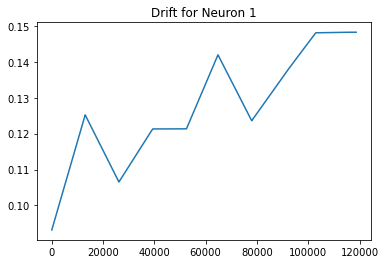

In [88]:
predRs = data.Xdrift @ driftw
m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

<Figure size 432x288 with 0 Axes>

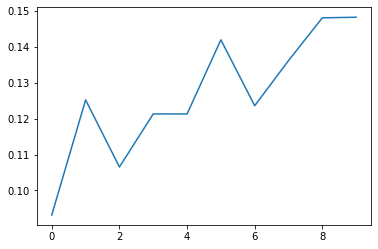

In [104]:
m.fig()
plt.plot(driftw.numpy()[:,0])
plt.show()

<Figure size 432x288 with 0 Axes>

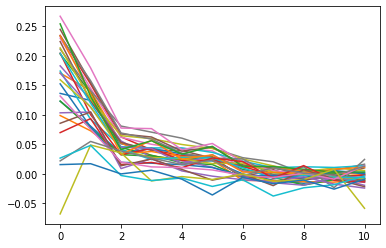

In [106]:
adaptw = model.networks[1].layers[0].weight.data
m.fig()
plt.plot(adaptw.numpy())
plt.show()

In [95]:
stimw = model.networks[2].layers[0].weight.data
data.stim.shape, stimw.shape, data.robs.shape

(torch.Size([118679, 132]), torch.Size([132, 31]), torch.Size([118679, 31]))

<Figure size 432x288 with 0 Axes>

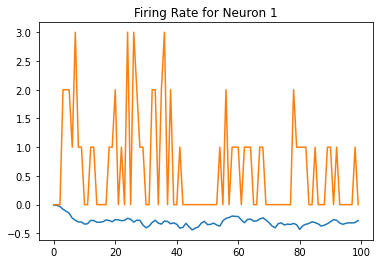

In [96]:
predRs = data.stim @ stimw
m.fig()
plt.plot(predRs[:,0][:100])
plt.plot(data.robs[:,0][:100])
plt.title("Firing Rate for Neuron 1")
plt.show()

In [ ]:
# TODO: create ADAPT features just for cued and for uncued trials and train those models?


In [ ]:
# TODO: combine cued/uncued with multiplication in its own network -- Does Attentional Gain affect firing in an additive or multiplicate way?
#       and compare accuracy with addition


In [ ]:
# TODO: add the autoencoder into the model and look at the latents,
#       see what they might be accounting for, now that we've accounted for Drift, Adaption and Stimulus
#       Do they show anything related to attention? This I will need to ASK DAN about once I get there, which is soon.

In [ ]:
# TODO: try projecting onto the cued/uncued thing and stuff like I did before, and if I don't understand it, ASK DAN.